# Machine Learning to Predict Costs and Evaluate Geographic Disparities

In [35]:
#Load the cleaned dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("cleaned_childcare_data.csv")

In [36]:
#Prep the data set
df_melted = df.melt(
    id_vars=['StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# Extract care type and age group
df_melted['care_type'] = df_melted['care_age'].apply(
    lambda x: 'in-home' if 'FCC' in x else 'center'
)
df_melted['age_group'] = df_melted['care_age'].str.extract(r'(Infant|Toddler|Preschool)')

df_melted['price'] = (
    df_melted['price']
    .astype(str)                             
    .str.replace(r'[\$,]', '', regex=True)   
    .str.replace(r'\s+', '', regex=True)     
    .replace('', np.nan)                    
    .astype(float)                          
)
print(df_melted['price'].isna().sum())
print(df_melted.shape)

# Group by year and care_type to get average
avg_prices = df_melted.groupby(['StudyYear', 'care_type'])['price'].mean().reset_index()

print(df_melted['price'].describe())


0
(72270, 5)
count    72270.000000
mean       143.957952
std         50.323744
min         46.450000
25%        111.252500
50%        131.580000
75%        163.295000
max        515.000000
Name: price, dtype: float64


In [37]:
# Find the state with the most expensive child care on average
# Melt data frame
df_melted = df.melt(
    id_vars=['State_Name', 'StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# 2. Clean the price column
df_melted['price'] = (
    df_melted['price']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# 3. Group by State and calculate average price
avg_price_by_state = df_melted.groupby('State_Name')['price'].mean().reset_index()

# 4. Sort to find the most expensive
top_states = avg_price_by_state.sort_values(by='price', ascending=False)

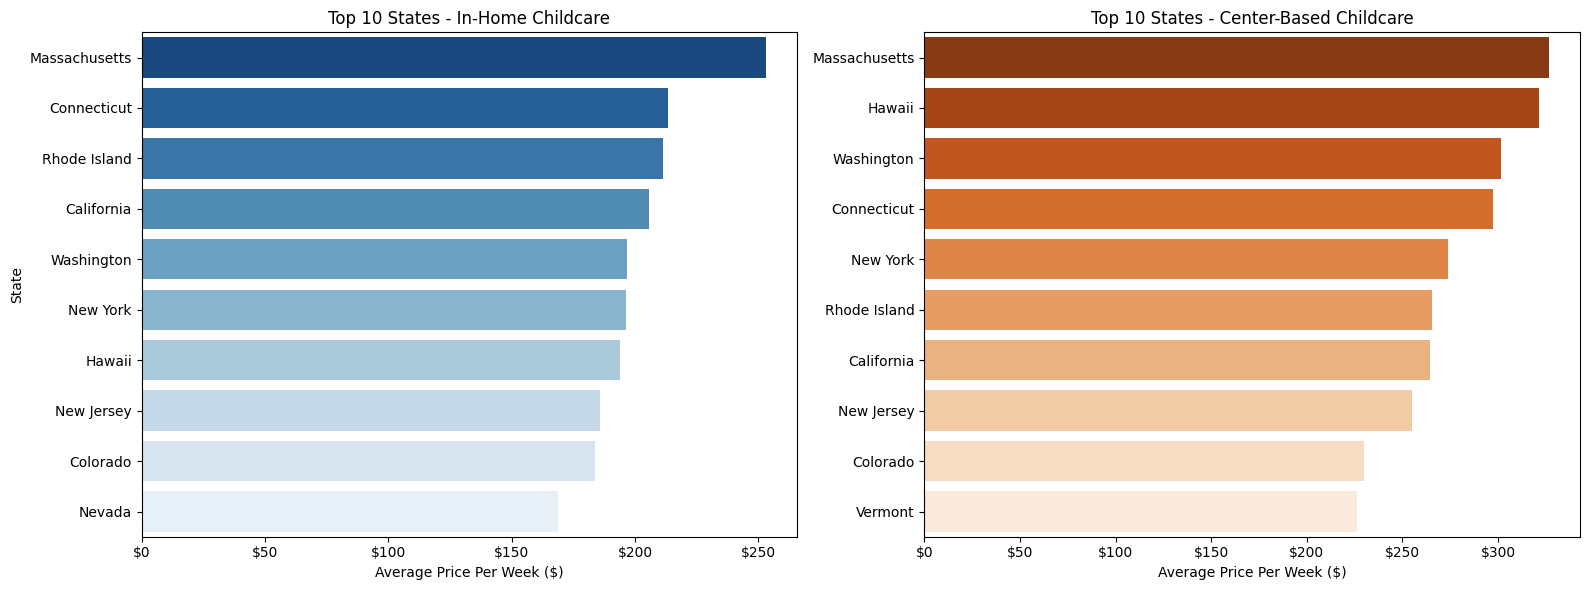

In [38]:
# Display states with most expensive childcare but differentiate between type of care
import matplotlib.ticker as mtick

# 1. Melt the dataframe
df_melted = df.melt(
    id_vars=['State_Name', 'StudyYear'],
    value_vars=[
        '_75FCCInfant', '_75FCCToddler', '_75FCCPreschool',
        '_75CInfant', '_75CToddler', '_75CPreschool'
    ],
    var_name='care_age',
    value_name='price'
)

# 2. Extract care type
df_melted['care_type'] = df_melted['care_age'].apply(
    lambda x: 'in-home' if 'FCC' in x else 'center'
)

# 3. Clean the price column
df_melted['price'] = (
    df_melted['price']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .str.replace(r'\s+', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# 4. Group by state and care type, then compute average price
avg_price_by_state_type = df_melted.groupby(['State_Name', 'care_type'])['price'].mean().reset_index()

# 5. Get top 10 for each care type
top10_inhome = avg_price_by_state_type[avg_price_by_state_type['care_type'] == 'in-home'] \
    .sort_values(by='price', ascending=False).head(10)

top10_center = avg_price_by_state_type[avg_price_by_state_type['care_type'] == 'center'] \
    .sort_values(by='price', ascending=False).head(10)

# 6. Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# In-home
sns.barplot(data=top10_inhome, x='price', y='State_Name', hue= 'State_Name', palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 States - In-Home Childcare')
axes[0].set_xlabel('Average Price Per Week ($)')
axes[0].set_ylabel('State')
axes[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Center-based
sns.barplot(data=top10_center, x='price', y='State_Name', hue= 'State_Name', palette='Oranges_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 States - Center-Based Childcare')
axes[1].set_xlabel('Average Price Per Week ($)')
axes[1].set_ylabel('')  # Don't repeat label
axes[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

In [39]:
# Create a linear regression model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Drop rows with missing prices
df_ml = df_melted.dropna(subset=['price'])

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_ml[['State_Name', 'StudyYear', 'care_type', 'care_age']], drop_first=True)

# Define features (X) and target (y)
X = df_encoded
y = df_ml['price']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
#Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [42]:
#Evaluate performance
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 30.67


In [43]:
#COmpare to other models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Dictionary to store models and their RMSEs
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN': KNeighborsRegressor()
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f'{name} RMSE: {rmse:.2f}')

Linear Regression RMSE: 30.67
Decision Tree RMSE: 28.52
Random Forest RMSE: 28.51
Gradient Boosting RMSE: 32.11
KNN RMSE: 31.06
